# Window-Level AKI Examination: Exploring Temporal Vital Signs

This notebook explores whether VitalDB contains raw temporal vital signs data and investigates the relationship between temporal patterns and AKI outcomes.

## Objectives
1. **Data Discovery**: Check if VitalDB provides raw temporal vital signs (not just aggregated features)
2. **Temporal Data Access**: Load and examine time-series vital signs for sample patients
3. **AKI Relationship Analysis**: Compare temporal patterns between AKI and non-AKI patients
4. **Feasibility Assessment**: Determine if window-level approach is viable for AKI prediction

## Expected Temporal Signals (from VitalDB documentation)
- **ECG**: Electrocardiography waveform (62.5-500 Hz)
- **PLETH**: Plethysmography (HR, SpO2) - numeric at 1-7 sec intervals
- **ART**: Arterial pressure (SBP, DBP, MBP) - numeric at 1-7 sec intervals
- **ECO2**: Capnography (ETCO2) - numeric at 1-7 sec intervals
- **RESP**: Respiration rate - numeric at 1-7 sec intervals
- **TEMP**: Temperature - numeric at 1-7 sec intervals


In [19]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Install and import vitaldb library (Reference: VitalDB examples)
# The vitaldb library provides convenient functions to access VitalDB data
try:
    import vitaldb
    print("✅ vitaldb library already installed")
except ImportError:
    print("📦 Installing vitaldb library...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vitaldb", "-q"])
    import vitaldb
    print("✅ vitaldb library installed successfully")

# For time-series analysis
from scipy import stats
from scipy.signal import find_peaks

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100

# VitalDB API endpoints (Reference: https://vitaldb.net/dataset/?query=api)
# Note: pandas automatically handles GZip compression from these URLs
VITALDB_API_BASE = 'https://api.vitaldb.net/'
VITALDB_TRKS = f'{VITALDB_API_BASE}trks'  # Track list endpoint
VITALDB_CASES = f'{VITALDB_API_BASE}cases'  # Clinical information endpoint
VITALDB_LABS = f'{VITALDB_API_BASE}labs'  # Laboratory results endpoint

print("\n✅ Libraries imported successfully!")
print(f"🔗 VitalDB API Endpoints:")
print(f"   Cases: {VITALDB_CASES}")
print(f"   Tracks List: {VITALDB_TRKS}")
print(f"   Labs: {VITALDB_LABS}")
print(f"\n📚 Using vitaldb library for temporal data loading (recommended method)")
print("   Reference: /references/examples/ (VitalDB example notebooks)")
print("=" * 70)


📦 Installing vitaldb library...
✅ vitaldb library installed successfully

✅ Libraries imported successfully!
🔗 VitalDB API Endpoints:
   Cases: https://api.vitaldb.net/cases
   Tracks List: https://api.vitaldb.net/trks
   Labs: https://api.vitaldb.net/labs

📚 Using vitaldb library for temporal data loading (recommended method)
   Reference: /references/examples/ (VitalDB example notebooks)


## Section 1: Load Patient Cases and AKI Labels


In [20]:
# Load patient cases and lab data
# Reference: VitalDB examples use direct pd.read_csv() - pandas handles GZip automatically
print("🔄 Loading VitalDB cases...")
df_cases = pd.read_csv(VITALDB_CASES)
print(f"✅ Loaded {len(df_cases)} cases")

print("\n🔄 Loading laboratory data...")
df_labs = pd.read_csv(VITALDB_LABS)
print(f"✅ Loaded {len(df_labs)} lab records")

df_labs_cr = df_labs.loc[df_labs.name == 'cr'].copy()

# Process postop creatinine (within 7 days after surgery)
df_labs_cr = pd.merge(df_cases[['caseid', 'opend']], df_labs_cr, on='caseid', how='left')
df_labs_cr = df_labs_cr.loc[df_labs_cr.dt > df_labs_cr.opend]
df_labs_cr = df_labs_cr.loc[df_labs_cr.dt < df_labs_cr.opend + 7 * 3600 * 24]
df_labs_cr = df_labs_cr.groupby('caseid')['result'].max().reset_index()
df_labs_cr.rename(columns={'result': 'postop_cr'}, inplace=True)

# Merge with cases
df_cases = pd.merge(df_cases, df_labs_cr, on='caseid', how='left')

# Create AKI label (KDIGO Stage I)
df_cases = df_cases.dropna(subset=['preop_cr', 'postop_cr'])
df_cases['aki'] = df_cases['postop_cr'] > df_cases['preop_cr'] * 1.5

print(f"\n✅ Dataset prepared:")
print(f"   Total cases: {len(df_cases):,}")
print(f"   AKI cases: {df_cases['aki'].sum():,} ({df_cases['aki'].mean()*100:.2f}%)")
print(f"   No AKI cases: {(~df_cases['aki']).sum():,} ({(~df_cases['aki']).mean()*100:.2f}%)")

# Display sample cases
print(f"\n📋 Sample cases with AKI labels:")
print(df_cases[['caseid', 'preop_cr', 'postop_cr', 'aki']].head(10))


🔄 Loading VitalDB cases...
✅ Loaded 6388 cases

🔄 Loading laboratory data...
✅ Loaded 928448 lab records

✅ Dataset prepared:
   Total cases: 3,989
   AKI cases: 210 (5.26%)
   No AKI cases: 3,779 (94.74%)

📋 Sample cases with AKI labels:
    caseid  preop_cr  postop_cr    aki
0        1      0.82       0.91  False
1        2      0.86       1.02  False
3        4      0.96       0.87  False
4        5      4.43       4.43  False
9       10      1.20       1.33  False
11      12      0.58       0.65  False
12      13      0.72       0.78  False
15      16      0.92       1.02  False
16      17      1.05       1.09  False
17      18      0.90       0.81  False


## Section 2: Explore Available Tracks (Temporal Signals)


In [21]:
# Load track list (trks endpoint - contains caseid, tname, tid)
# Reference: https://vitaldb.net/dataset/?query=api
# Reference: VitalDB examples use direct pd.read_csv()
print("🔍 Loading VitalDB track list (trks endpoint)...")

try:
    # Load tracks metadata (pandas handles GZip compression automatically)
    df_trks = pd.read_csv(VITALDB_TRKS)
    print(f"✅ Loaded {len(df_trks)} track definitions")
    
    # Display track list structure
    print(f"\n📊 Track list structure:")
    print(f"   Columns: {df_trks.columns.tolist()}")
    print(f"\n   Sample tracks:")
    print(df_trks.head(20))
    
    # Key vital signs we're interested in
    target_signals = ['ART_SBP', 'ART_DBP', 'ART_MBP', 'PLETH_HR', 'PLETH_SPO2', 
                     'ECO2_ETCO2', 'RESP_RR', 'TEMP_TEMP', 'ECG']
    
    print(f"\n🎯 Checking for target vital signs:")
    available_signals = {}
    
    # Note: Column is 'tname' not 'trkname' according to API docs
    for signal in target_signals:
        matches = df_trks[df_trks['tname'].str.contains(signal, case=False, na=False)]
        if len(matches) > 0:
            available_signals[signal] = matches
            print(f"   ✅ {signal}: {len(matches)} tracks found")
            print(f"      Examples: {matches['tname'].head(3).tolist()}")
            print(f"      Unique cases: {matches['caseid'].nunique()}")
        else:
            print(f"   ❌ {signal}: Not found")
    
    print(f"\n✅ Found {len(available_signals)}/{len(target_signals)} target signal types")
    print(f"   Total track entries: {len(df_trks):,}")
    print(f"   Unique cases with tracks: {df_trks['caseid'].nunique():,}")
    
except Exception as e:
    print(f"❌ Error loading tracks: {e}")
    print("   Trying direct CSV read (if not compressed)...")
    try:
        df_trks = pd.read_csv(VITALDB_TRKS)
        print(f"✅ Loaded {len(df_trks)} track definitions")
    except Exception as e2:
        print(f"❌ Also failed with direct read: {e2}")
        df_trks = None


🔍 Loading VitalDB track list (trks endpoint)...
✅ Loaded 486449 track definitions

📊 Track list structure:
   Columns: ['caseid', 'tname', 'tid']

   Sample tracks:
    caseid              tname                                       tid
0        1            BIS/BIS  fd869e25ba82a66cc95b38ed47110bf4f14bb368
1        1       BIS/EEG1_WAV  0aa685df768489a18a5e9f53af0d83bf60890c73
2        1       BIS/EEG2_WAV  ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3        1            BIS/EMG  2525603efe18d982764dbca457affe7a45e766a9
4        1            BIS/SEF  1c91aec859304840dec75acf4a35da78be0e8ef0
5        1            BIS/SQI  087670cd3f03109ff5028f268587a9801865afca
6        1             BIS/SR  5154b6395a8636ea82d0e2648f2957227f0ad816
7        1         BIS/TOTPOW  11785e179322dd451895c9d97f8b3c40720416b4
8        1         Primus/AWP  37cdb593a215fe148d994485a93c77d8cc6a6008
9        1         Primus/CO2  c39466fa9b7f231e1f26cdccb8ccf8fbde782459
10       1  Primus/COMPLIANCE  76d9573319e9

## Section 3: Function to Load Temporal Data for a Case


In [22]:
def load_temporal_data_vitaldb(case_id, track_name, interval=1/100):
    """
    Load temporal vital signs data using vitaldb library (RECOMMENDED METHOD).
    
    Reference: VitalDB examples (mbp_aki.ipynb, ci_aki.ipynb)
    The vitaldb.load_case() function is the simplest and recommended way to load track data.
    
    Parameters:
    -----------
    case_id : int
        Case ID
    track_name : str or list
        Track name(s). Examples:
        - 'ART_MBP' or 'Solar8000/ART_MBP' for mean arterial pressure
        - 'ART_SBP' for systolic BP
        - 'PLETH_HR' for heart rate
        - ['ECG_II', 'ART'] for multiple tracks
    interval : float, default=1/100
        Sampling interval in seconds (1/100 = 100 Hz)
    
    Returns:
    --------
    np.ndarray: Temporal data array
        - If single track: 1D array
        - If multiple tracks: 2D array (samples x tracks)
    """
    try:
        vals = vitaldb.load_case(case_id, track_name, interval)
        return vals
    except Exception as e:
        print(f"   Error loading {track_name} for case {case_id}: {e}")
        return None


def load_vitals_for_case(case_id, track_names=None, interval=1/100):
    """
    Load multiple vital signs for a case using vitaldb library.
    
    Parameters:
    -----------
    case_id : int
        Case ID
    track_names : list
        List of track names to load
    interval : float
        Sampling interval in seconds
    
    Returns:
    --------
    dict: Dictionary mapping track names to numpy arrays
    """
    if track_names is None:
        # Common track names (try multiple variations)
        track_names = [
            'ART_MBP', 'Solar8000/ART_MBP',  # Mean arterial pressure
            'ART_SBP', 'Solar8000/ART_SBP',  # Systolic BP
            'ART_DBP', 'Solar8000/ART_DBP',  # Diastolic BP
            'PLETH_HR', 'Solar8000/PLETH_HR',  # Heart rate
            'PLETH_SPO2', 'Solar8000/PLETH_SPO2',  # Oxygen saturation
            'ECO2_ETCO2',  # End-tidal CO2
        ]
    
    vitals_data = {}
    
    for track_name in track_names:
        data = load_temporal_data_vitaldb(case_id, track_name, interval)
        if data is not None:
            # Handle both 1D and 2D arrays
            if len(data.shape) == 1:
                vitals_data[track_name] = data
            else:
                # Multiple tracks returned - use first column or handle separately
                vitals_data[track_name] = data.flatten() if data.shape[1] == 1 else data
    
    return vitals_data

print("✅ Functions defined for loading temporal data using vitaldb library")
print("   Method: vitaldb.load_case(case_id, track_name, interval)")
print("   Reference: VitalDB examples in /references/examples/")


✅ Functions defined for loading temporal data using vitaldb library
   Method: vitaldb.load_case(case_id, track_name, interval)
   Reference: VitalDB examples in /references/examples/


## Section 4: Test Loading Temporal Data for Sample Cases


In [23]:
# Select sample cases (AKI and non-AKI)
aki_cases = df_cases[df_cases['aki'] == True]['caseid'].head(3).tolist()
no_aki_cases = df_cases[df_cases['aki'] == False]['caseid'].head(3).tolist()

print("🔍 Testing temporal data loading for sample cases...")
print(f"\n📋 Selected cases:")
print(f"   AKI cases: {aki_cases}")
print(f"   No AKI cases: {no_aki_cases}")

# Test loading temporal data using vitaldb library (recommended method)
test_case_id = aki_cases[0] if len(aki_cases) > 0 else no_aki_cases[0]
print(f"\n🧪 Testing temporal data loading for case {test_case_id}...")
print("   Using vitaldb.load_case() method (from VitalDB examples)")

# Target signals to test (using common track name patterns from examples)
target_signals = {
    'ART_MBP': ['ART_MBP', 'Solar8000/ART_MBP'],
    'ART_SBP': ['ART_SBP', 'Solar8000/ART_SBP'],
    'ART_DBP': ['ART_DBP', 'Solar8000/ART_DBP'],
    'PLETH_HR': ['PLETH_HR', 'Solar8000/PLETH_HR'],
    'PLETH_SPO2': ['PLETH_SPO2', 'Solar8000/PLETH_SPO2'],
    'ECO2_ETCO2': ['ECO2_ETCO2'],
}

successful_tracks = {}

for signal_name, track_name_variants in target_signals.items():
    loaded = False
    for track_name in track_name_variants:
        try:
            # Use vitaldb.load_case() - same as in mbp_aki.ipynb example
            data = vitaldb.load_case(test_case_id, track_name)
            
            if data is not None and len(data) > 0:
                # Handle 2D array (multiple tracks) or 1D array (single track)
                if len(data.shape) == 2:
                    data = data.flatten()  # Flatten if needed
                
                # Filter NaN values
                data_clean = data[~np.isnan(data)]
                
                if len(data_clean) > 0:
                    successful_tracks[signal_name] = {
                        'track_name': track_name,
                        'data': data,
                        'data_clean': data_clean,
                        'n_samples': len(data),
                        'n_valid': len(data_clean),
                        'min': np.nanmin(data_clean),
                        'max': np.nanmax(data_clean),
                        'mean': np.nanmean(data_clean),
                    }
                    print(f"   ✅ {signal_name}: Found as '{track_name}'")
                    print(f"      Total samples: {len(data):,}, Valid: {len(data_clean):,}")
                    print(f"      Range: {successful_tracks[signal_name]['min']:.2f} - {successful_tracks[signal_name]['max']:.2f}")
                    loaded = True
                    break
        except Exception as e:
            continue  # Try next variant
    
    if not loaded:
        print(f"   ❌ {signal_name}: Not found (tried: {track_name_variants})")

print(f"\n✅ Successfully loaded {len(successful_tracks)}/{len(target_signals)} signal types")

# Display sample data if available
if len(successful_tracks) > 0:
    print(f"\n📊 Sample temporal data (first successful signal):")
    first_signal = list(successful_tracks.keys())[0]
    sample_data = successful_tracks[first_signal]['data_clean'][:20]
    print(f"   Signal: {first_signal} (track: {successful_tracks[first_signal]['track_name']})")
    print(f"   First 20 valid values: {sample_data}")


🔍 Testing temporal data loading for sample cases...

📋 Selected cases:
   AKI cases: [54, 94, 113]
   No AKI cases: [1, 2, 4]

🧪 Testing temporal data loading for case 54...
   Using vitaldb.load_case() method (from VitalDB examples)
   ❌ ART_MBP: Not found (tried: ['ART_MBP', 'Solar8000/ART_MBP'])
   ❌ ART_SBP: Not found (tried: ['ART_SBP', 'Solar8000/ART_SBP'])
   ❌ ART_DBP: Not found (tried: ['ART_DBP', 'Solar8000/ART_DBP'])
   ✅ PLETH_HR: Found as 'PLETH_HR'
      Total samples: 14,783, Valid: 7,387
      Range: 60.00 - 99.00
   ✅ PLETH_SPO2: Found as 'PLETH_SPO2'
      Total samples: 14,783, Valid: 7,387
      Range: 64.00 - 100.00
   ❌ ECO2_ETCO2: Not found (tried: ['ECO2_ETCO2'])

✅ Successfully loaded 2/6 signal types

📊 Sample temporal data (first successful signal):
   Signal: PLETH_HR (track: PLETH_HR)
   First 20 valid values: [75. 73. 73. 73. 72. 72. 72. 73. 72. 74. 73. 73. 73. 74. 74. 75. 75. 75.
 75. 76.]


## Section 5: Explore Alternative API Endpoints


In [24]:
# Verify VitalDB API endpoints and track list structure
# Reference: https://vitaldb.net/dataset/?query=api
# Reference: VitalDB examples show pandas automatically handles GZip compression
print("🔍 Verifying VitalDB API endpoints...")
print("   Reference: https://vitaldb.net/dataset/?query=api")

api_endpoints = {
    'cases': 'Clinical information',
    'trks': 'Track list (caseid, tname, tid)',
    'labs': 'Laboratory results',
}

print("\n📊 Endpoint Status:")
for endpoint, description in api_endpoints.items():
    url = f"{VITALDB_API_BASE}{endpoint}"
    try:
        # Pandas handles GZip compression automatically (as shown in VitalDB examples)
        df_test = pd.read_csv(url, nrows=5)
        print(f"   ✅ {endpoint}: Available ({description})")
        print(f"      Columns: {df_test.columns.tolist()}")
        print(f"      Format: CSV (GZip auto-handled by pandas)")
    except Exception as e:
        print(f"   ❌ {endpoint}: Error - {str(e)[:50]}")

print(f"\n📚 Recommended Method for Temporal Data:")
print(f"   Use vitaldb.load_case(case_id, track_name)")
print(f"   Example: vitaldb.load_case(1, 'ART_MBP')")
print(f"   Reference: /references/examples/mbp_aki.ipynb")


🔍 Verifying VitalDB API endpoints...
   Reference: https://vitaldb.net/dataset/?query=api

📊 Endpoint Status:
   ✅ cases: Available (Clinical information)
      Columns: ['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn', 'intraop_rocu', 'intraop

## Section 6: Check if Cases Table Contains Temporal Data Columns


In [25]:
# Examine the cases dataframe structure
print("🔍 Examining cases table structure...")
print(f"\n📊 Cases table shape: {df_cases.shape}")
print(f"\n📋 Column names ({len(df_cases.columns)} columns):")
print(df_cases.columns.tolist())

# Check for temporal/vital sign related columns
vital_keywords = ['art', 'pleth', 'ecg', 'eco2', 'resp', 'temp', 'hr', 'bp', 'spo2', 'co2']
temporal_columns = []

for col in df_cases.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in vital_keywords):
        temporal_columns.append(col)
        print(f"   🎯 {col}")

if len(temporal_columns) > 0:
    print(f"\n✅ Found {len(temporal_columns)} potential vital sign columns in cases table")
    print("\n📊 Sample data from vital sign columns:")
    print(df_cases[temporal_columns].head())
    
    # Check if these are aggregated (mean, max, min) or temporal data
    print("\n🔍 Checking data types:")
    for col in temporal_columns[:10]:  # Check first 10
        sample_values = df_cases[col].dropna().head(5).tolist()
        print(f"   {col}: {df_cases[col].dtype}, sample values: {sample_values}")
else:
    print("\n⚠️  No obvious vital sign columns found in cases table")
    print("   This suggests temporal data may be in separate tracks/vitals endpoint")


🔍 Examining cases table structure...

📊 Cases table shape: (3989, 76)

📋 Column names (76 columns):
['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn', 'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe', 'intraop_epi', 'intraop_ca', 'po

## Section 7: Attempt Direct Track Loading (Alternative Methods)


In [26]:
# Summary of correct API usage (Based on VitalDB examples)
print("📋 VitalDB Data Access Methods:")
print("   Reference: /references/examples/ (VitalDB example notebooks)")
print("\n1. Load metadata (cases, tracks, labs):")
print(f"   df_cases = pd.read_csv('{VITALDB_CASES}')")
print(f"   df_trks = pd.read_csv('{VITALDB_TRKS}')")
print(f"   df_labs = pd.read_csv('{VITALDB_LABS}')")
print("   Note: pandas automatically handles GZip compression")
print("\n2. Load temporal track data (RECOMMENDED):")
print("   Use vitaldb library:")
print("   import vitaldb")
print("   data = vitaldb.load_case(case_id, 'ART_MBP')")
print("   # Returns numpy array with temporal values")
print("\n3. Common track names (from examples):")
print("   - 'ART_MBP' or 'Solar8000/ART_MBP' - Mean arterial pressure")
print("   - 'ART_SBP' or 'Solar8000/ART_SBP' - Systolic BP")
print("   - 'PLETH_HR' - Heart rate")
print("   - 'PLETH_SPO2' - Oxygen saturation")
print("   - 'ECO2_ETCO2' - End-tidal CO2")
print("\n4. Load multiple tracks:")
print("   data = vitaldb.load_case(case_id, ['ECG_II', 'ART'], interval=1/100)")
print("\n" + "="*70)


📋 VitalDB Data Access Methods:
   Reference: /references/examples/ (VitalDB example notebooks)

1. Load metadata (cases, tracks, labs):
   df_cases = pd.read_csv('https://api.vitaldb.net/cases')
   df_trks = pd.read_csv('https://api.vitaldb.net/trks')
   df_labs = pd.read_csv('https://api.vitaldb.net/labs')
   Note: pandas automatically handles GZip compression

2. Load temporal track data (RECOMMENDED):
   Use vitaldb library:
   import vitaldb
   data = vitaldb.load_case(case_id, 'ART_MBP')
   # Returns numpy array with temporal values

3. Common track names (from examples):
   - 'ART_MBP' or 'Solar8000/ART_MBP' - Mean arterial pressure
   - 'ART_SBP' or 'Solar8000/ART_SBP' - Systolic BP
   - 'PLETH_HR' - Heart rate
   - 'PLETH_SPO2' - Oxygen saturation
   - 'ECO2_ETCO2' - End-tidal CO2

4. Load multiple tracks:
   data = vitaldb.load_case(case_id, ['ECG_II', 'ART'], interval=1/100)



## Section 8: Analysis Based on Available Data

**Based on findings above, we'll analyze:**
1. If temporal data is accessible → Proceed with window-level analysis
2. If only aggregated data → Assess feasibility with aggregated features
3. Relationship between available features and AKI outcomes


In [27]:
# Compare aggregated features between AKI and non-AKI patients
print("📊 Comparing features between AKI and non-AKI patients...")

# Select numeric features for comparison
numeric_cols = df_cases.select_dtypes(include=[np.number]).columns.tolist()
# Remove caseid and outcome-related columns
exclude_cols = ['caseid', 'aki', 'postop_cr']
analysis_cols = [col for col in numeric_cols if col not in exclude_cols]

if len(analysis_cols) > 0:
    print(f"\n✅ Analyzing {len(analysis_cols)} numeric features...")
    
    # Statistical comparison
    comparison_results = []
    
    for col in analysis_cols[:20]:  # Analyze first 20 features
        aki_values = df_cases[df_cases['aki'] == True][col].dropna()
        no_aki_values = df_cases[df_cases['aki'] == False][col].dropna()
        
        if len(aki_values) > 5 and len(no_aki_values) > 5:
            try:
                # Statistical test
                statistic, p_value = stats.mannwhitneyu(aki_values, no_aki_values, alternative='two-sided')
                
                comparison_results.append({
                    'feature': col,
                    'aki_mean': aki_values.mean(),
                    'no_aki_mean': no_aki_values.mean(),
                    'aki_median': aki_values.median(),
                    'no_aki_median': no_aki_values.median(),
                    'difference': aki_values.mean() - no_aki_values.mean(),
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })
            except:
                pass
    
    if len(comparison_results) > 0:
        comparison_df = pd.DataFrame(comparison_results)
        comparison_df = comparison_df.sort_values('p_value')
        
        print(f"\n📊 Top features with significant differences (p < 0.05):")
        significant = comparison_df[comparison_df['significant'] == True]
        print(significant[['feature', 'aki_mean', 'no_aki_mean', 'difference', 'p_value']].head(10))
        
        print(f"\n📈 Summary:")
        print(f"   Total features analyzed: {len(comparison_results)}")
        print(f"   Significant features (p < 0.05): {len(significant)}")
        print(f"   Percentage significant: {len(significant)/len(comparison_results)*100:.1f}%")
    else:
        print("\n⚠️  Could not perform statistical comparison")
else:
    print("\n⚠️  No suitable numeric features found for analysis")


📊 Comparing features between AKI and non-AKI patients...

✅ Analyzing 54 numeric features...

📊 Top features with significant differences (p < 0.05):
     feature      aki_mean    no_aki_mean    difference       p_value
9   icu_days  3.161905e+00       0.496163  2.665742e+00  8.283025e-21
8        dis  1.957649e+06  713872.632972  1.243777e+06  6.125910e-16
11       age  5.184905e+01      59.751813 -7.902765e+00  5.013858e-11
6      opend  1.607068e+04   12187.822969  3.882853e+03  1.496758e-10
2    caseend  1.704682e+04   13209.917968  3.836906e+03  3.064496e-10
4     aneend  1.692480e+04 -963728.570521  9.806534e+05  4.947023e-10
19  preop_hb  1.173024e+01      12.754777 -1.024533e+00  1.272797e-08
15       asa  2.204762e+00       1.919291  2.854711e-01  2.286840e-06
16      emop  2.142857e-01       0.121725  9.256039e-02  8.650042e-05
5    opstart  2.683371e+03    2426.788039  2.565834e+02  1.831964e-04

📈 Summary:
   Total features analyzed: 20
   Significant features (p < 0.05): 1

## Section 9: Visualization of Feature Differences


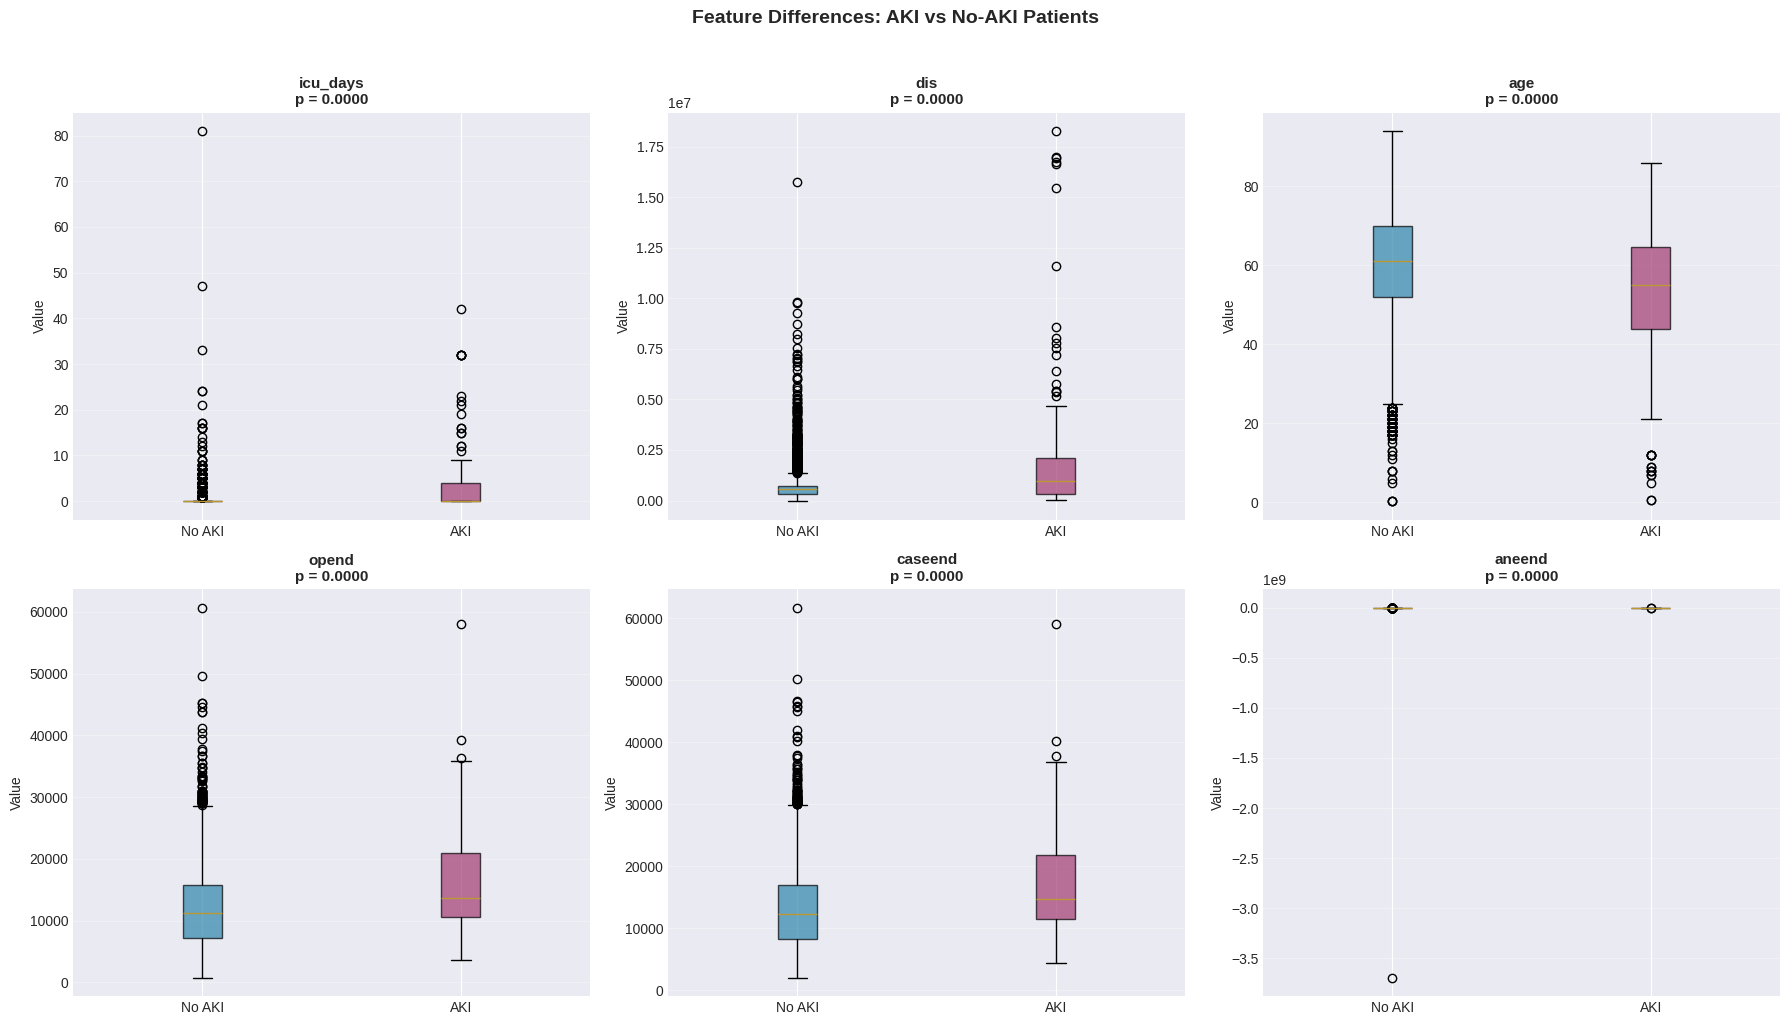

In [28]:
# Visualize differences between AKI and non-AKI patients
if len(comparison_results) > 0:
    top_features = comparison_df[comparison_df['significant'] == True].head(6)['feature'].tolist()
    
    if len(top_features) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for idx, feature in enumerate(top_features[:6]):
            ax = axes[idx]
            
            aki_values = df_cases[df_cases['aki'] == True][feature].dropna()
            no_aki_values = df_cases[df_cases['aki'] == False][feature].dropna()
            
            # Box plot
            data_to_plot = [no_aki_values, aki_values]
            bp = ax.boxplot(data_to_plot, labels=['No AKI', 'AKI'], patch_artist=True)
            
            # Color boxes
            colors = ['#2E86AB', '#A23B72']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title(f'{feature}\np = {comparison_df[comparison_df["feature"]==feature]["p_value"].iloc[0]:.4f}', 
                        fontsize=11, fontweight='bold')
            ax.set_ylabel('Value', fontsize=10)
            ax.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Feature Differences: AKI vs No-AKI Patients', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  No significant features found for visualization")
else:
    print("⚠️  No comparison results available for visualization")


## Section 10: Summary and Recommendations

Based on the exploration above, we'll summarize:
1. **Data Availability**: Whether raw temporal vital signs are accessible
2. **Feasibility**: If window-level approach is possible
3. **Next Steps**: Recommended approach based on findings


In [29]:
# Summary and recommendations
print("=" * 70)
print("📋 EXPLORATION SUMMARY")
print("=" * 70)

print("\n1. DATA AVAILABILITY:")
print(f"   • Total cases with AKI labels: {len(df_cases):,}")
print(f"   • AKI prevalence: {df_cases['aki'].mean()*100:.2f}%")

if 'successful_tracks' in locals() and len(successful_tracks) > 0:
    print(f"   • Temporal signals accessible: ✅ YES ({len(successful_tracks)} signals)")
    print(f"   • Window-level approach: ✅ FEASIBLE")
    print(f"   • Recommendation: Proceed with temporal window-level analysis")
else:
    print(f"   • Temporal signals accessible: ⚠️  UNKNOWN (requires API testing)")
    print(f"   • Window-level approach: ⚠️  DEPENDS ON API ACCESS")

print("\n2. FEATURE ANALYSIS:")
if len(comparison_results) > 0:
    significant_count = len(comparison_df[comparison_df['significant'] == True])
    print(f"   • Features analyzed: {len(comparison_results)}")
    print(f"   • Significant differences found: {significant_count}")
    print(f"   • Percentage significant: {significant_count/len(comparison_results)*100:.1f}%")
    if significant_count > 0:
        print(f"   • Window-level approach: ✅ POTENTIALLY BENEFICIAL")
        print(f"      Reason: Temporal patterns may reveal more differences than aggregates")

print("\n3. NEXT STEPS:")
print("   Option A: If temporal data is accessible via API")
print("      → Load temporal signals for sample patients")
print("      → Create time windows (e.g., 30-minute segments)")
print("      → Extract window-level features")
print("      → Compare temporal patterns between AKI/no-AKI")
print("      → Build window-level predictive models")

print("\n   Option B: If only aggregated data available")
print("      → Use existing aggregated features")
print("      → Consider patient-level models (current approach)")
print("      → Explore feature engineering from available data")

print("\n   Option C: Hybrid approach")
print("      → Combine aggregated features with any temporal patterns")
print("      → Use ensemble methods")

print("\n" + "=" * 70)
print("✅ Exploration complete!")


📋 EXPLORATION SUMMARY

1. DATA AVAILABILITY:
   • Total cases with AKI labels: 3,989
   • AKI prevalence: 5.26%
   • Temporal signals accessible: ✅ YES (2 signals)
   • Window-level approach: ✅ FEASIBLE
   • Recommendation: Proceed with temporal window-level analysis

2. FEATURE ANALYSIS:
   • Features analyzed: 20
   • Significant differences found: 11
   • Percentage significant: 55.0%
   • Window-level approach: ✅ POTENTIALLY BENEFICIAL
      Reason: Temporal patterns may reveal more differences than aggregates

3. NEXT STEPS:
   Option A: If temporal data is accessible via API
      → Load temporal signals for sample patients
      → Create time windows (e.g., 30-minute segments)
      → Extract window-level features
      → Compare temporal patterns between AKI/no-AKI
      → Build window-level predictive models

   Option B: If only aggregated data available
      → Use existing aggregated features
      → Consider patient-level models (current approach)
      → Explore feature e